# 0.03 Generate Anomalies S2S

---

Uses the climatology generated in `0.02_generate_climatology_S2S` to create anomalies from the S2S forecasting system.

In [1]:
#%load_ext lab_black

import xarray as xr
import glob

from dask.distributed import Client

In [2]:
client = Client("tcp://10.12.205.28:33631")

In [3]:
clim = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.climatology.zarr/",consolidated=True)
raw = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.raw.zarr/", consolidated=True)

Going to just create ensemble mean anomalies for now. Having a little trouble with chunking strategies to get anomalies generated for each ensemble member. **NOTE**: If you want to have individual ensemble member anomalies for e.g. probabilistic metrics, just do it for each member separately (e.g. `raw.isel(member=0)` and so on) then save them out separately and concatenate them later.

In [40]:
mem = 4

In [41]:
#ensmean = raw.mean("member")
ensmean = raw.isel(member=mem)

In [42]:
# Matching the chunking strategy for `clim` to make the computation more efficient.
ensmean = ensmean.chunk({"lead": 1, "lat": -1, "lon": 180, "init": "auto"}).persist()

In [43]:
#%time anoms = [raw.isel(member=m).groupby("init.dayofyear") - clim for m in range(10)]
anom = ensmean.groupby("init.dayofyear") - clim

Generally have to rechunk after an operation like this to make sure chunk sizes are uniform. Also doing a groupby command like that returns a result with really small chunks. Keep in mind with `zarr` the power is that they get loaded in chunk-aware. So I make the inits one large chunk, knowing we'll operate on the full init dimension with `climpred` for operations.

In [44]:
%time anom = anom.chunk({"lat": "auto", "lon": "auto", "init": -1, "lead": 1}).persist()

CPU times: user 8.42 s, sys: 692 ms, total: 9.11 s
Wall time: 10 s


In [45]:
anom

<xarray.Dataset>
Dimensions:    (init: 655, lat: 181, lead: 46, lon: 360)
Coordinates:
  * init       (init) object 1999-02-01 00:00:00 ... 2016-10-31 00:00:00
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lead       (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    member     int64 5
    dayofyear  (init) int64 dask.array<chunksize=(655,), meta=np.ndarray>
Data variables:
    TAS        (init, lead, lat, lon) float32 dask.array<chunksize=(655, 1, 181, 180), meta=np.ndarray>

In [46]:
%time anom.to_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anom.mem"+str(mem)+".zarr/", consolidated=True)

CPU times: user 2.46 s, sys: 1.36 s, total: 3.82 s
Wall time: 2min 39s


Looks like they are in anomaly format!

In [47]:
test = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anom.mem"+str(mem)+".zarr/", consolidated=True)

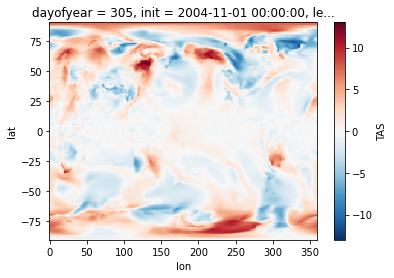

In [48]:
test.TAS.isel(init=10, lead=10).plot()

### This next section reads in each member and concatenates them into one anom file that still has all members

In [49]:
#anom0 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem0.zarr/", consolidated=True)
#anom1 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem1.zarr/", consolidated=True)
#anom2 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem2.zarr/", consolidated=True)
#anom3 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem3.zarr/", consolidated=True)
#anom4 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem4.zarr/", consolidated=True)
#anom5 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem5.zarr/", consolidated=True)
#anom6 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem6.zarr/", consolidated=True)
#anom7 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem7.zarr/", consolidated=True)
#anom8 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem8.zarr/", consolidated=True)
#anom9 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem9.zarr/", consolidated=True)
#anom10 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anom.mem10.zarr/", consolidated=True)
anom0 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anom.mem0.zarr/", consolidated=True)
anom1 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anom.mem1.zarr/", consolidated=True)
anom2 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anom.mem2.zarr/", consolidated=True)
anom3 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anom.mem3.zarr/", consolidated=True)
anom4 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anom.mem4.zarr/", consolidated=True)

In [50]:
#anom0 = anom0.sortby("init").persist()
#anom1 = anom1.sortby("init").persist()
#anom2 = anom2.sortby("init").persist()
#anom3 = anom3.sortby("init").persist()
#anom4 = anom4.sortby("init").persist()
#anom5 = anom5.sortby("init").persist()
#anom6 = anom6.sortby("init").persist()
#anom7 = anom7.sortby("init").persist()
#anom8 = anom8.sortby("init").persist()
#anom9 = anom9.sortby("init").persist()
#anom10 = anom10.sortby("init").persist()
anom0 = anom0.sortby("init").persist()
anom1 = anom1.sortby("init").persist()
anom2 = anom2.sortby("init").persist()
anom3 = anom3.sortby("init").persist()
anom4 = anom4.sortby("init").persist()

/glade/work/jaye/miniconda3/envs/s2s/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/work/jaye/miniconda3/envs/s2s/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 120 times more chunks
  return self.array[key]
/glade/work/jaye/miniconda3/envs/s2s/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': F

In [51]:
#%time anoms = xr.concat((anom0,anom1,anom2,anom3,anom4,anom5,anom6,anom7,anom8,anom9,anom10),dim="member")
%time anoms = xr.concat((anom0,anom1,anom2,anom3,anom4),dim="member")

CPU times: user 285 ms, sys: 38.6 ms, total: 324 ms
Wall time: 517 ms


In [52]:
anoms

,Array,Chunk
Bytes,39.27 GB,85.36 MB
Shape,"(5, 655, 46, 181, 360)","(1, 655, 1, 181, 180)"
Count,1380 Tasks,460 Chunks
Type,float32,numpy.ndarray


In [53]:
anoms = anoms.chunk({"lat": "auto", "lon": "auto", "init": -1, "lead": 1, "member": -1}).persist()

In [54]:
#%time anoms.to_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anoms.zarr/", consolidated=True)
%time anoms.to_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anoms.zarr/", consolidated=True)

CPU times: user 135 ms, sys: 32.7 ms, total: 168 ms
Wall time: 7.96 s


In [55]:
#test = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anoms.zarr/", consolidated=True)
test = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/WACCM.S2S.tas_2m.anoms.zarr/", consolidated=True)

In [56]:
test

<xarray.Dataset>
Dimensions:    (init: 655, lat: 181, lead: 46, lon: 360, member: 5)
Coordinates:
    dayofyear  (init) int64 dask.array<chunksize=(211,), meta=np.ndarray>
  * init       (init) object 1999-01-04 00:00:00 ... 2020-10-26 00:00:00
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lead       (lead) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * member     (member) int64 1 2 3 4 5
Data variables:
    TAS        (member, init, lead, lat, lon) float32 dask.array<chunksize=(5, 655, 1, 112, 90), meta=np.ndarray>